# MNIST Classifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

df_raw = pd.read_pickle('results.pkl')

In [2]:
df_raw.head()

Classifier LogisticRegression             GaussianNB              LinearSVC  \
Method             Prediction Probability Prediction Probability Prediction   
0                         1.0    0.979908        1.0         1.0        1.0   
1                         1.0    0.968832        1.0         1.0        1.0   
2                         1.0    0.972728        1.0         1.0        1.0   
3                         1.0    0.999986        1.0         1.0        1.0   
4                         1.0    0.815760        1.0         1.0        1.0   

Classifier             RandomForestClassifier             SGDClassifier  \
Method     Probability             Prediction Probability    Prediction   
0             0.627873                    1.0         1.0           1.0   
1             0.574250                    1.0         1.0           1.0   
2             0.578030                    1.0         1.0           1.0   
3             0.775335                    1.0         1.0           1.0   
4             0.574944                    1.0         1.0           1.0   

Classifier             KNeighborsClassifier             actual  
Method     Probability           Prediction Probability         
0             0.626272                  1.0         1.0   True  
1             0.631219                  1.0         1.0   True  
2             0.629980                  1.0         1.0   True  
3             0.747994                  1.0         1.0   True  
4             0.549328                  1.0         1.0   True

In [3]:
actual = df_raw.actual.copy()
preds = df_raw.xs('Prediction', level='Method', axis=1)
probs = df_raw.xs('Probability', level='Method', axis=1)

### Basic Classifier Scores

In [4]:
# Display some summary data about the classifiers
from sklearn.metrics import (precision_recall_curve, brier_score_loss,
                             accuracy_score, precision_score, recall_score, f1_score)

from functools import partial

pre = preds.agg(partial(precision_score, actual))
rec = preds.agg(partial(recall_score, actual))
acc = preds.agg(partial(accuracy_score, actual))
f_1 = preds.agg(partial(f1_score, actual))
total = preds.agg(sum)

stats = pd.DataFrame([total, acc, pre, rec, f_1], 
                     index=('Total', 'Accuracy', 'Precision', 'Recall', 'F1 Score'))
stats

Classifier,LogisticRegression,GaussianNB,LinearSVC,RandomForestClassifier,SGDClassifier,KNeighborsClassifier
Total,4961.000000,5476.000000,5159.000000,4857.000000,4339.000000,4872.000000
Accuracy,0.899500,0.800400,0.854300,0.970700,0.860700,0.985200
Precision,0.895182,0.767531,0.836209,0.976940,0.907121,0.990353
Recall,0.901543,0.853228,0.875761,0.963256,0.799026,0.979497
F1 Score,0.898351,0.808114,0.855528,0.970050,0.849649,0.984895


### Precision-Recall

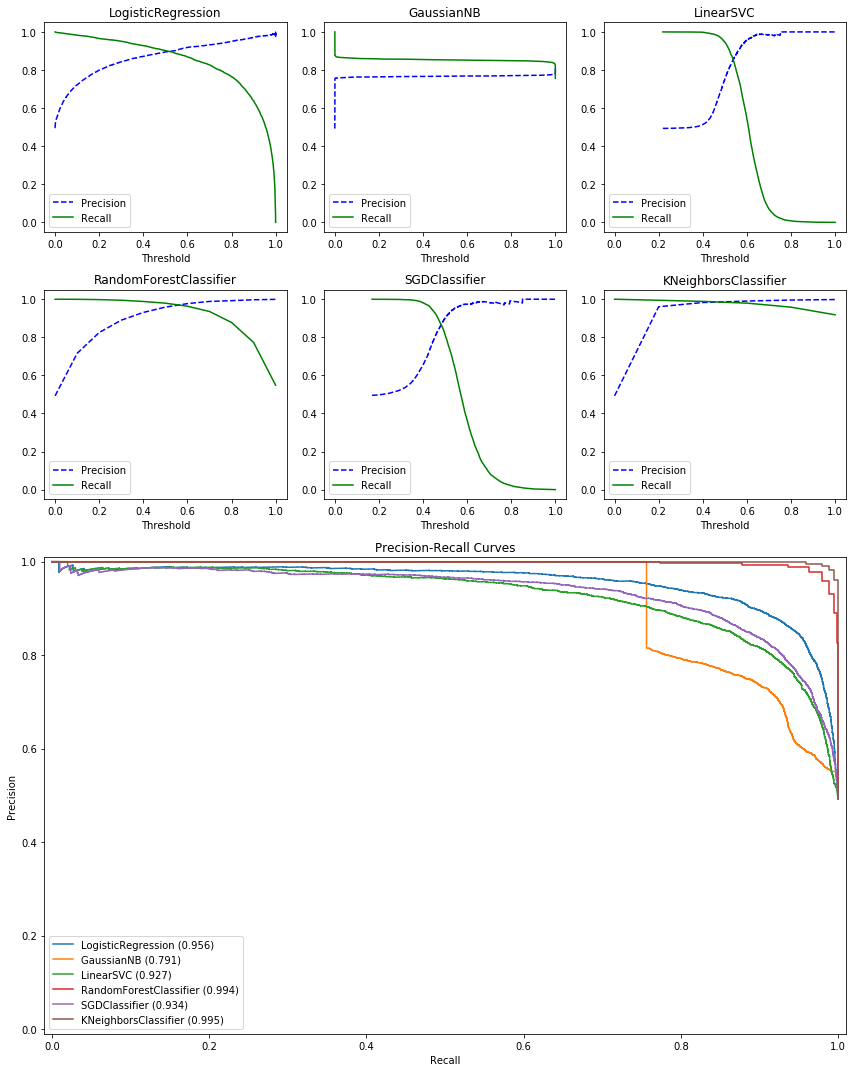

In [5]:
from sklearn.metrics import average_precision_score
avg_precs = probs.agg(partial(average_precision_score, actual))

# Precision-Recall Curves Against Threshold per Classifier
curves = probs.agg(partial(precision_recall_curve, actual))

# for label, curve in curves.iteritems():
#     print(f'{label}:')
#     print(f'\tPrecisions: {curve[0].min():1.3f} {curve[0].max():1.3f}')
#     print(f'\tRecalls:    {curve[1].min():1.3f} {curve[1].max():1.3f}')
#     print(f'\tThresholds: {curve[2].min():1.3f} {curve[2].max():1.3f}')
#     print()
figsize = (12, 15)
gridsize = (4, 3)

plt.figure(1, figsize=figsize)
axes = [plt.subplot2grid(gridsize, (m, n))
        for m in range(2)
        for n in range(3)]

ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=3, rowspan=2)
# fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(12, 12))
# ax2 = plt.figure(2, figsize=(6, 6)).subplots()

for ax, (label, curve) in zip(axes, curves.iteritems()):
    precisions, recalls, thresholds = curve
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    ax.set_xlabel('Threshold')
    ax.legend(loc='lower left')
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([-0.05, 1.05])
    ax.set_title(label)
    ap = avg_precs[label]
    ax2.step(recalls, precisions, label=f'{label} ({ap:.3f})')
    
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
ax2.set_title('Precision-Recall Curves')
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()

### ROC / AUC